# Cost-constrained QR (CCQR)
This notebook explores the `PySensors` cost-constrained QR `CCQR` optimizer for cost-constrained sparse sensor placement (for reconstruction).

Suppose we are interested in reconstructing a field based on a limited set of measurements.
Examples:
* Fluid flows (estimating the drag on an airplane wing with pressure sensors on different parts of the wing)
* Atmospheric dynamics (approximating the concentrations of different molecules based on measurements taken at only a few locations)
* Sea-surface temperature (predicting the temperature at any point on the ocean based on the temperatures measured at various other points on the ocean)

In other notebooks we have shown how one can use the `SSPOR` class to pick optimal locations in which to place sensors to accomplish this task. But so far we have treated all sensor locations as being equally viable. What happens when some sensor locations are more expensive than others? For example, it might be ten times as costly to place and maintain a buoy measuring the sea-surface temperature in the middle of the Atlantic compared to one close to the coast.

The cost-constrained QR algorithm was devised specifically to solve such problems. The `PySensors` object implementing this method is named `CCQR` and in this notebook we'll demonstrate its use on a toy problem.

See the following reference for more information ([link](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8579238))

    Clark, Emily, et al. "Greedy sensor placement with cost constraints." IEEE Sensors Journal 19.7 (2018): 2642-2656.

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

import pysensors as ps

## Setup

We'll consider the Olivetti faces dataset from AT&T. Our goal will be to reconstruct images of faces from a limited set of measurements.

First we've got to load and preprocess the data.

In [2]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print(n_samples, n_features)

400 4096


In [3]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [4]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

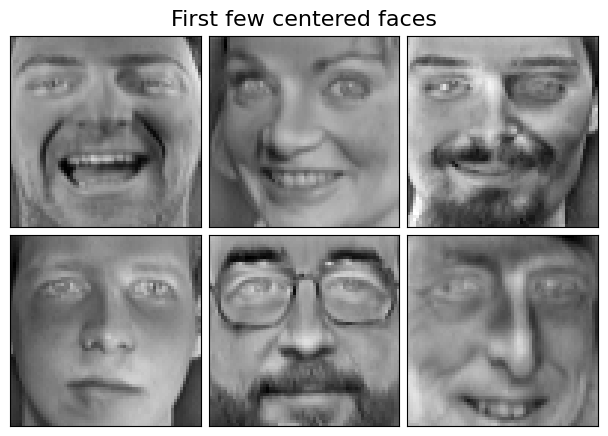

In [5]:
plot_gallery("First few centered faces", X[:n_components])

We'll learn the sensors using the first 300 faces and use the rest for testing reconstruction error.

In [6]:
X_train, X_test = X[:300], X[300:]

## Sensor costs
In order for `CCQR` to decide which sensors are most important, it needs to know the costs associated with each of them. To this end, one must construct an array specifying these costs. Larger costs/values will make `CCQR` less likely to pick a given sensor, and smaller ones will have the opposite effect.

We'll consider three different sets of sensor costs:

* Zero cost: all sensors have zero cost
* Center blocked: sensors within a square near the center of the image have a fixed positive cost and others have none
* Left blocked: sensors on the left side of the image have a fixed positive cost and others have none

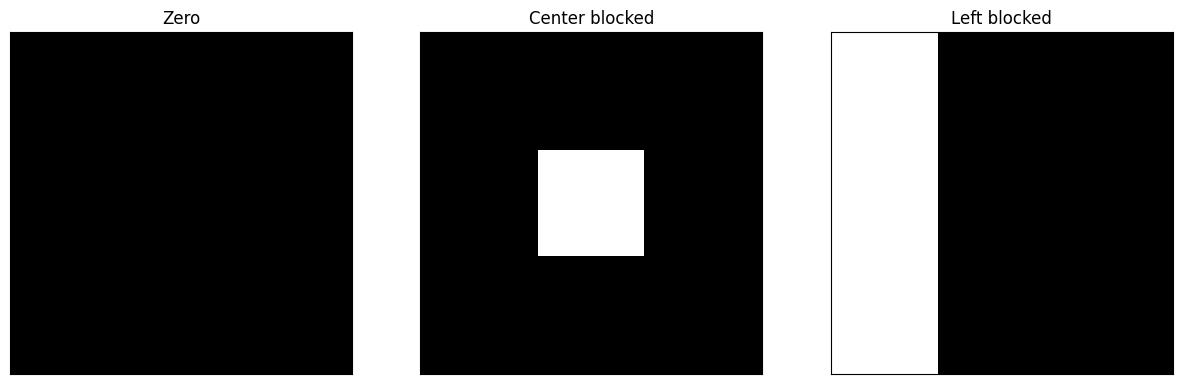

In [7]:
cost_names = ('Zero', 'Center blocked', 'Left blocked')
sensor_costs = {}

# Zero cost
sensor_costs['Zero'] = np.zeros(image_shape).reshape(-1)

# Center blocked
costs = np.zeros(image_shape)
w = 10
costs[(32 - w):(32 + w), (32 - w):(32 + w)] = 1
sensor_costs['Center blocked'] = costs.reshape(-1)

# Left blocked
costs = np.zeros(image_shape)
costs[:, :20] = 1
sensor_costs['Left blocked'] = costs.reshape(-1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for name, ax in zip(cost_names, axs):
    ax.imshow(sensor_costs[name].reshape(image_shape), vmin=0, vmax=1, cmap=plt.cm.gray)
    ax.set(title=name, xticks=[], yticks=[]);

Next we'll apply `CCQR` with each of the above cost functions, plotting learned sensor locations and a few examples of reconstructed faces from the test set.

Note that the mean-square error (MSE) reported in the first row is the MSE across all images in the test set. For the later rows, we give the MSE for the particular image being shown.

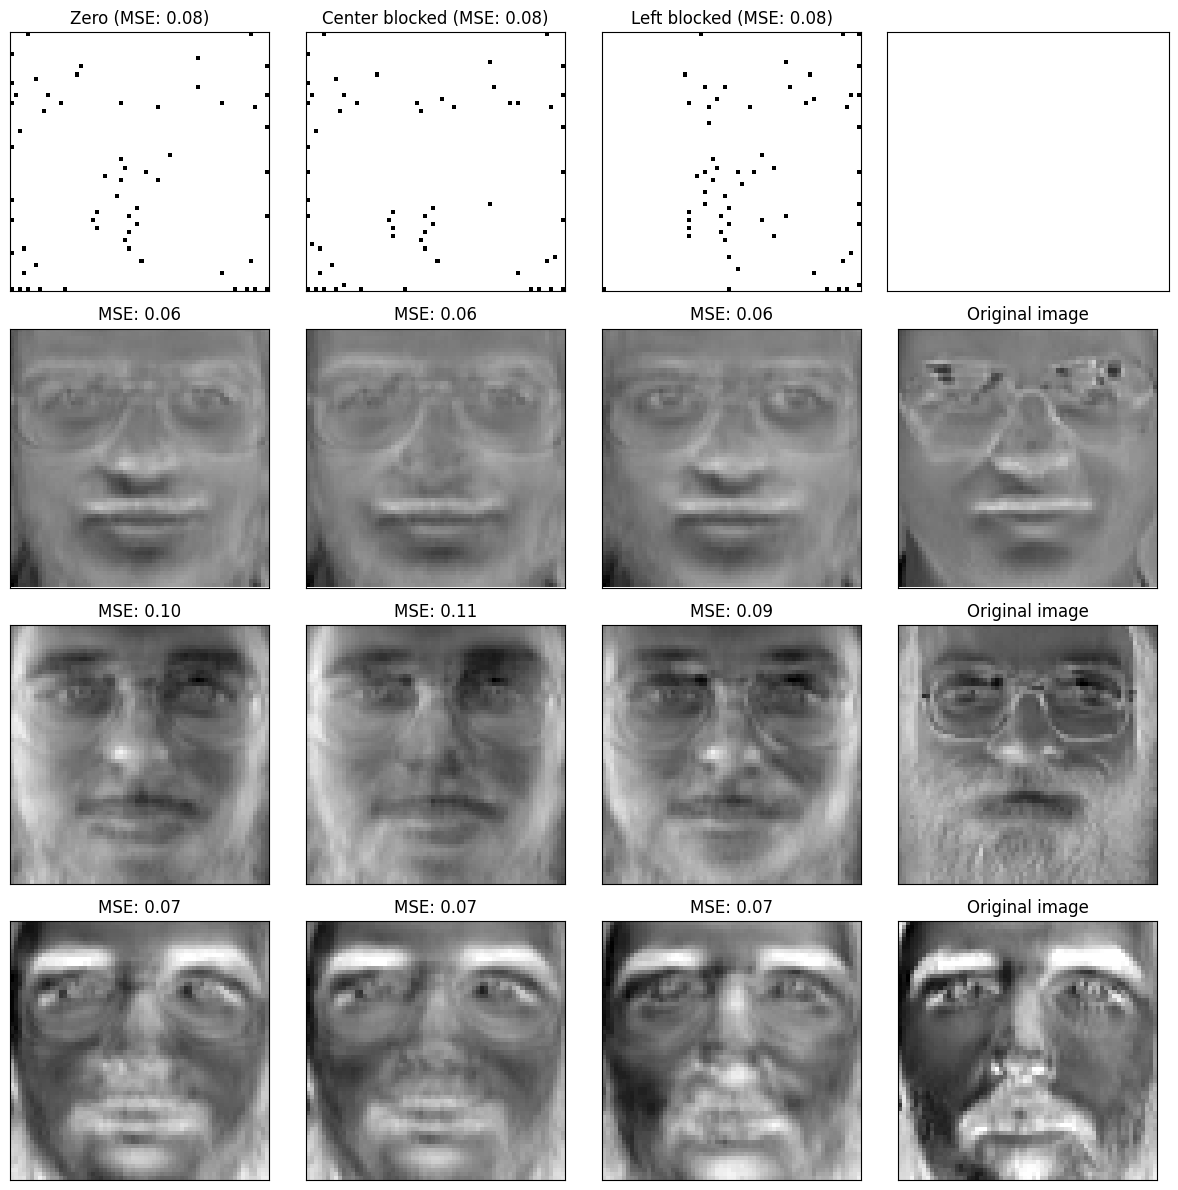

In [8]:
n_sensors = 60
n_faces = 3
n_rows = n_faces + 1
fig, axs = plt.subplots(n_rows, 4, figsize=(12, 3 * n_rows))

for k, cost_name in enumerate(cost_names):
    # Define the cost-constrained QR optimizer
    optimizer = ps.optimizers.CCQR(sensor_costs=sensor_costs[cost_name])
    basis = ps.basis.SVD(n_basis_modes=50)
    
    # Initialize and fit the model
    model = ps.SSPOR(n_sensors=n_sensors, optimizer=optimizer)
    model.fit(X_train)
    
    # Get average reconstruction error across test set
    test_error = model.reconstruction_error(X_test, sensor_range=[n_sensors])
    
    # Plot sensor locations
    sensors = model.get_selected_sensors()
    img = np.zeros(n_features)
    img[sensors] = 16
    
    axs[0, k].imshow(img.reshape(image_shape), cmap=plt.cm.binary)
    axs[0, k].set(
        title=f"{cost_name} (MSE: {test_error[0]:.2f})"
    )
    
    # Plot reconstructed faces
    for j in range(n_faces):
        idx = 10 * j
        img = model.predict(X_test[idx, sensors], method='unregularized')
        vmax = max(img.max(), img.min())
        axs[j + 1, k].imshow(
            img.reshape(image_shape),
            cmap=plt.cm.binary,
            vmin=-vmax,
            vmax=vmax
        )
        error = model.reconstruction_error(X_test[idx], sensor_range=[n_sensors])[0]
        axs[j + 1, k].set(title=f"MSE: {error:.2f}")
        
        # Plot target image
        true_img = X_test[idx]
        vmax = max(true_img.max(), true_img.min())
        axs[j + 1, k + 1].imshow(
            true_img.reshape(image_shape),
            cmap=plt.cm.binary,
            vmin=-vmax,
            vmax=vmax
        )
        axs[j + 1, k + 1].set(title="Original image")
        

[ax.set(xticks=[], yticks=[]) for ax in axs.flatten()]
fig.tight_layout()

Observations:

* Using "center blocked" costs causes sensors in the center of the image to be avoided
* Using "left blocked" costs causes sensors on the left of the image to be avoided
* In all cases more sensors are needed for accurate reconstructions
* With a limited number of sensors, models have a hard time with high-frequency features like the texture of a beard